### Keras RNN으로 여행자 수 예측

1. 패키지 수입 및 파라미터 설정

In [4]:
# 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
# StandardScaler는 z-점수 정규화를 확인해보기 위함(연습)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Dense
from keras.layers import LSTM, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [5]:
# 하이퍼 파라미터
MY_PAST = 12
MY_SPLIT = 0.8
MY_HIDDEN = 300 # 은닉층 뉴런 개수 지정
MY_SHAPE = (MY_PAST, 1) 
MY_EPOCH = 300 # 반복 학습 횟수

2. 데이터 불러오기 및 선처리

In [6]:
# 데이터 읽기
# data frame
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/airline.csv', 
                  header=None, # 콜롬명이 없다는 것을 알림. 이를 제외하면 첫번째 데이터 손실
                  usecols=[1]) # 사용할 열이 1번째임

# 샘플 출력. 컬럼명이 없으므로 1로 출력됨
print(raw.head(15))
print(raw.describe()) # 통계

      1
0   112
1   118
2   132
3   129
4   121
5   135
6   148
7   148
8   136
9   119
10  104
11  118
12  115
13  126
14  141
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


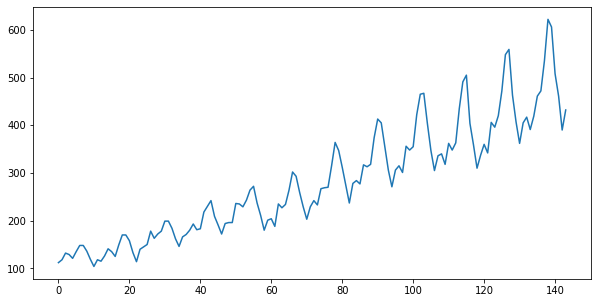

In [7]:
# 데이터 시각화
plt.figure(figsize=(10,5)) # 캔버스의 크기
plt.plot(raw)

<class 'numpy.ndarray'>
[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 0.24324324 0.26640927 0.2027027  0.16795367 0.13127413 0.17374517
 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 0.38223938 0.36486486 0.2992278  0.24131274 0.19111969 0.24131274
 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 0.5019305  0.46911197 0.4015444  0.32818533 0.25675676 0.33590734
 0.34749035 0.33397683 0.41119691 0.40

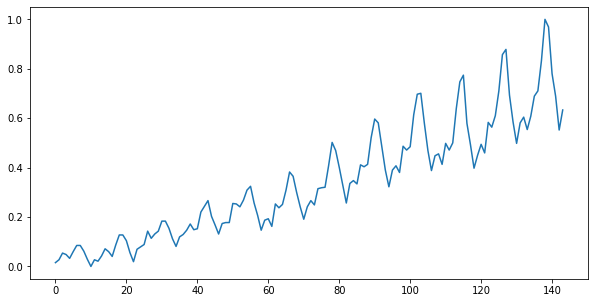

In [8]:
# 데이터 정규화
scaler = MinMaxScaler() # 결과로 numpy type

# z-점수 정규화 확인(연습) - 평균을 0으로, 표준편차를 1로
# scaler = StandardScaler()

s_data = scaler.fit_transform(raw) # 0~1 사이의 값

print(type(s_data))
print(s_data.flatten())

plt.figure(figsize=(10,5))
plt.plot(s_data)

In [9]:
# 데이터 분할
data = []
for i in range(len(s_data) - MY_PAST):
    data.append(s_data[i : i + MY_PAST + 1])

print('한 묶음의 크기 :', len(data[0]))
print('총 묶음 수 :',len(data))
print('첫번째 묶음 내용\n', data[0])
print('두번째 묶음 내용\n', data[1])

한 묶음의 크기 : 13
총 묶음 수 : 132
첫번째 묶음 내용
 [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]]
두번째 묶음 내용
 [[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]]


In [10]:
# 데이터를 numpy로 전환
print(type(data))
data = np.array(data)
print(type(data))

# 묶음들을 임의로 섞음
#np.random.shuffle(data)
print(data.shape) # 이때, 출력되는 1은 3차원 데이터를 의미. 숫자들이 개별적으로 하나의 차원을 구성

#  데이터를 입력과 출력으로 분할
X_data = data[:, 0:MY_PAST]
Y_data = data[:, -1]

print('입력 데이터 모양 :',X_data.shape)
print('출력 데이터 모양 :',Y_data.shape)

<class 'list'>
<class 'numpy.ndarray'>
(132, 13, 1)
입력 데이터 모양 : (132, 12, 1)
출력 데이터 모양 : (132, 1)


In [11]:
# 데이터 4분할
X_train, X_test,Y_train, Y_test = train_test_split(X_data,
                                                   Y_data,
                                                   train_size=MY_SPLIT,
                                                   shuffle=False) # 셔플 제거

# 최종 데이터 모양 출력
print('학습용 입력 데이터 모양 :', X_train.shape)
print('학습용 출력 데이터 모양 :', Y_train.shape)
print('평가용 입력 데이터 모양 :', X_test.shape)
print('평가용 출력 데이터 모양 :', Y_test.shape)

학습용 입력 데이터 모양 : (105, 12, 1)
학습용 출력 데이터 모양 : (105, 1)
평가용 입력 데이터 모양 : (27, 12, 1)
평가용 출력 데이터 모양 : (27, 1)


3. 인공 신경망 구현

In [12]:
# RNN 구현
model = Sequential()

# (12, 1)인 이유 : LSTM에서는 숫자 하나하나가 각자의 차원을 이루어야 함
model.add(InputLayer(input_shape=MY_SHAPE))

model.add(LSTM(units=MY_HIDDEN))

model.add(Dense(units=1,
                activation='tanh')) # sigmoid는 숫자 하나를 0~1 사이의 확률로 변환하는 활성화 함수 
 
print('RNN 요약')
model.summary()

RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [13]:
# RNN 학습 설정 
model.compile(optimizer='rmsprop',
              loss='mse') # 손실 함수 : 예측값이 정답에서 몇 % 벗어나는지
              # metrics=['acc'] : 정확도를 보지 않으므로 생략 가능

print('학습 시작')
begin = time()

model.fit(x=X_train,
          y=Y_train,
          epochs=MY_EPOCH,
          verbose=0)

end = time()
print('학습 시간 : {:.2f}'.format(end - begin))


학습 시작
학습 시간 : 12.92


5. 인공 신경망 평가

In [14]:
# RNN 평가
score = model.evaluate(x=X_test,
                       y=Y_test,
                       verbose=0)

print('최종 손실값 :', score)
# print('최종 정확도 :', score[1]) : 무의미

최종 손실값 : 0.0028141075745224953


6. 인공 신경망 예측

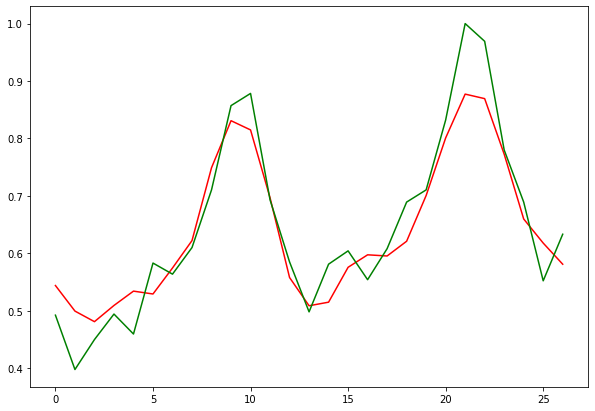

In [15]:
# RNN으로 예측
pred = model.predict(x=X_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred, 'r') # 추측 데이터를 red로 표현
plt.plot(Y_test, 'g') # 정답

In [16]:
print('역전환 전 :',pred) # 27개의 평가용 데이터 출력. 0~1 사이의 값 출력 - sigmoid로 인해
print(pred.shape)

# 데이터 역전환
pred = scaler.inverse_transform(pred)

print('역전환 후 :',pred)
print(pred.shape)

# squeeze 결과
tmp = np.squeeze(pred).astype(int) # astype으로 int형으로 변환
print('squeeze 후 :',tmp)
print(tmp.shape)

역전환 전 : [[0.5439063 ]
 [0.49939898]
 [0.48097607]
 [0.5092045 ]
 [0.5341444 ]
 [0.52916324]
 [0.57442904]
 [0.62216157]
 [0.74902   ]
 [0.83088595]
 [0.8148274 ]
 [0.69667095]
 [0.55782497]
 [0.5086795 ]
 [0.514913  ]
 [0.57563543]
 [0.59737635]
 [0.595345  ]
 [0.62100595]
 [0.7006128 ]
 [0.80086714]
 [0.87719184]
 [0.8693177 ]
 [0.77265126]
 [0.6597729 ]
 [0.6178282 ]
 [0.58100486]]
(27, 1)
역전환 후 : [[385.74347]
 [362.68866]
 [353.1456 ]
 [367.76794]
 [380.6868 ]
 [378.10657]
 [401.55426]
 [426.2797 ]
 [491.99237]
 [534.3989 ]
 [526.0806 ]
 [464.87558]
 [392.95334]
 [367.496  ]
 [370.72495]
 [402.17917]
 [413.44095]
 [412.38873]
 [425.6811 ]
 [466.91745]
 [518.8492 ]
 [558.3854 ]
 [554.3066 ]
 [504.23337]
 [445.76236]
 [424.035  ]
 [404.96054]]
(27, 1)
squeeze 후 : [385 362 353 367 380 378 401 426 491 534 526 464 392 367 370 402 413 412
 425 466 518 558 554 504 445 424 404]
(27,)


역전환 전 정답: [[0.49227799]
 [0.3976834 ]
 [0.44980695]
 [0.49420849]
 [0.45945946]
 [0.58301158]
 [0.56370656]
 [0.61003861]
 [0.71042471]
 [0.85714286]
 [0.87837838]
 [0.69305019]
 [0.58494208]
 [0.4980695 ]
 [0.58108108]
 [0.6042471 ]
 [0.55405405]
 [0.60810811]
 [0.68918919]
 [0.71042471]
 [0.83204633]
 [1.        ]
 [0.96911197]
 [0.77992278]
 [0.68918919]
 [0.55212355]
 [0.63320463]]
역전환 후 정답 : [[359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]
 [472.]
 [548.]
 [559.]
 [463.]
 [407.]
 [362.]
 [405.]
 [417.]
 [391.]
 [419.]
 [461.]
 [472.]
 [535.]
 [622.]
 [606.]
 [508.]
 [461.]
 [390.]
 [432.]]


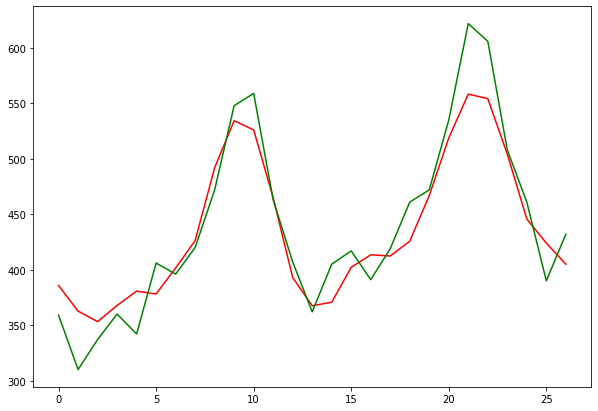

In [17]:
# 정답 출력
print('역전환 전 정답:', Y_test) # MinMaxScaler()로 0~1 사이의 값이 나옴

# 역전환
Y_test = scaler.inverse_transform(Y_test)
print('역전환 후 정답 :', Y_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred, 'r') # 추측 데이터를 red로 표현
plt.plot(Y_test, 'g') # 정답